## Training a GAN on Fashion MNIST

#### Setting for hot reloading of modules

In [1]:
%load_ext autoreload
%autoreload 2

#### Importing modules

In [2]:
import lightning as L
import torchvision
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger

from src.dataset.FashionMNISTDataModule import FashionMNISTDataModule
from src.models.discriminator import Discriminator
from src.models.generator import Generator
from src.train.wrapper.gan_wrapper import GANWrapper
from src.utils.constants import Paths
from src.utils.helpers import detect_device, matplotlib_imshow

#### Setting up the data

In [3]:
BATCH_SIZE = 1024

#### Downloading and preparing the data

In [4]:
fashionMNISTDataModule = FashionMNISTDataModule(Paths.DATA_DIR, BATCH_SIZE)
fashionMNISTDataModule.setup('fit')

# Report split sizes
print('Training set has {} instances'.format(len(fashionMNISTDataModule.train_dataloader()) * BATCH_SIZE))
print('Validation set has {} instances'.format(len(fashionMNISTDataModule.val_dataloader()) * BATCH_SIZE))

Training set has 60416 instances
Validation set has 10240 instances


#### Defining the model hyperparameters

In [5]:
z_dim = 128
generator_input_dim = z_dim + fashionMNISTDataModule.num_classes()
input_channels = 1
discriminator_input_dim = input_channels + fashionMNISTDataModule.num_classes()

#### Visualizing the data

torch.Size([3, 3842, 242])
T-shirt/top  Pullover  Shirt  Sandal


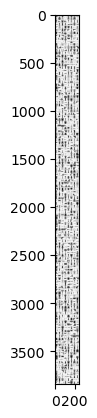

In [6]:
dataiter = iter(fashionMNISTDataModule.train_dataloader())
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(fashionMNISTDataModule.dataset_classes()[labels[j]] for j in range(4)))

#### Defining the model

In [7]:
generator = Generator(generator_input_dim, input_channels)
discriminator = Discriminator(discriminator_input_dim)

gan_wrapper = GANWrapper(generator, discriminator, z_dim, fashionMNISTDataModule.num_classes(), display_every_n_steps=100)

#### Defining the training parameters

In [8]:
logger = TensorBoardLogger(Paths.LOGS_DIR, name='gan_training.logs')
checkpoint_callback = ModelCheckpoint(dirpath=Paths.MODEL_CHECKPOINT_DIR,
                                      filename='gan-{epoch:02d}-{val_generator_loss:.2f}', save_top_k=3,
                                      monitor='val_generator_loss')

In [9]:
# %load_ext tensorboard
# %tensorboard --logdir /logs/gan_training.logs

#### Training the model

In [ ]:
trainer = L.Trainer(default_root_dir=Paths.MODEL_CHECKPOINT_DIR, max_epochs=10000, callbacks=[checkpoint_callback],
                    logger=logger, accelerator=detect_device(), enable_checkpointing=True, log_every_n_steps=50)

trainer.fit(gan_wrapper, datamodule=fashionMNISTDataModule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
C:\Users\gabri\miniconda3\envs\augment-aid-ml\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:654: Checkpoint directory D:\Projects\Github\augment-aid-ml\assets\model_checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params | Mode 
------------------------------------------------------------
0 | generator     | Generator         | 1.2 M  | train
1 | discriminator | Discriminator     | 672 K  | train
2 | criterion     | BCEWithLo

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]